In [1]:
# Importando os módulos que serão utilizados

import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import time
import dill
import pandas as pd
import plotly.express as ply_exp
import plotly.graph_objects as ply_go

# Importando os módulos contendo as funções criadas no projeto

from aux_train import *
from aux_plot import *
from aux_func_V3 import *
import API_Numpy
import API_TensorFlow

float_pres = 'float64' # Definindo a precisão padrão para as análises

In [6]:
nomes = [
    "WENO-JS"     , "WENO-Z"      , "WENO-Zp"     , 
    "WENO-JS (M)" , "WENO-Z (M)"  , "WENO-Zp (M)" , 
    "WENO-JS (MS)", "WENO-Z (MS)" , "WENO-Zp (MS)", 
    "WENO-JS (BI)", "WENO-Z (BI)" , "WENO-Zp (BI)",
    "WENO-ZC (MS)", "WENO-ZC (BI)"
]

API      = API_Numpy
equation = transp_equation

WENOs = {}
for nome in nomes:
    WENOs[nome]=WENO_dict[nome](API,equation,5/3)

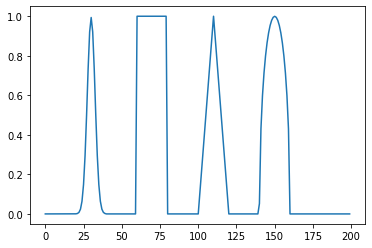

In [7]:
Δx = 0.01

# f_test = lambda x: np.where(x > 0.5, 0.0, 1.0)*np.where(x < -0.5, 0.0, 1.0)

def f_test(x):
    z = tf.constant(-0.7, dtype=float_pres)
    δ = tf.constant(0.005, dtype=float_pres)
    β = tf.math.log(tf.constant(2.0, dtype=float_pres))/(36.0*(δ**2.0))
    a = tf.constant(0.5, dtype=float_pres)
    α = tf.constant(10, dtype=float_pres)
    
    def G(x, β, z):
        return tf.math.exp(-β*(x-z)**2)
    
    def F(x, α, a):
        return tf.math.sqrt(tf.math.maximum(1-(α**2)*((x-a)**2),0))
    
    f1 = (G(x, β, z-δ) + 4*G(x, β, z) + G(x, β, z+δ))/6 # x in [-0.8, -0.6]
    f2 = 1                                              # x in [-0.4, -0.2]
    f3 = 1-tf.math.abs(10*(x-0.1))                      # x in [ 0.0,  0.2]
    f4 = (F(x, α, a-δ) + 4*F(x, α, a) + F(x, α, a+δ))/6 # x in [ 0.4,  0.6]
    f5 = 0                                              # otherwise
    
    condition = tf.math.logical_and(
        tf.math.greater_equal(x, -0.8),
        tf.math.less_equal(x, -0.6)
    )
    f1 = f1*tf.cast(tf.where(condition, 1.0, 0.0), dtype=float_pres)
    
    condition = tf.math.logical_and(
        tf.math.greater_equal(x, -0.4),
        tf.math.less_equal(x, -0.2)
    )
    f2 = f2*tf.cast(tf.where(condition, 1.0, 0.0), dtype=float_pres)
    
    condition = tf.math.logical_and(
        tf.math.greater_equal(x, 0.0),
        tf.math.less_equal(x, 0.2)
    )
    f3 = f3*tf.cast(tf.where(condition, 1.0, 0.0), dtype=float_pres)
    
    condition = tf.math.logical_and(
        tf.math.greater_equal(x, 0.4),
        tf.math.less_equal(x, 0.6)
    )
    f4 = f4*tf.cast(tf.where(condition, 1.0, 0.0), dtype=float_pres)
    
    f = f1 + f2 + f3 + f4 + f5
    
    return f

plt.plot(f_test(tf.range(-1, 1, Δx, dtype=float_pres)))

In [88]:
fronteira = FronteiraPeriodica

t_median  = {}
t_up  = {}
t_down  = {}

t_mean  = {}
t_icu  = {}
t_icl  = {}

N  = 1000

for nome in nomes:
    t_median[nome]=[]
    t_up[nome]=[]
    t_down[nome]=[]

    t_mean[nome]=[]
    t_icu[nome]=[]
    t_icl[nome]=[]

    get_weight_func=WENOs[nome].Get_weights
    # get_weight_func=WENOs[nome].DerivadaEspacial
    for n in range(200,1000,100):
        #n       = 400
        Δx = 2/n
        x  = tf.range(-1, 1, Δx, dtype=float_pres)

        data_x=slicer(f_test(x),5,API)
        # data_x=f_test(x)
        t_values=[]
        for i in range(N):
            print(i,"              ",end='\r')
            tempo=time.time()
            ref_u = get_weight_func(data_x, Δx)
            # ref_u = get_weight_func(data_x, Δx,fronteira)
            tempo_final=time.time()-tempo
            t_values.append(tempo_final)
        t_median[nome].append(np.quantile(t_values,0.5))
        t_down[nome].append(np.quantile(t_values,0.25))
        t_up[nome].append(np.quantile(t_values,0.75))

        t_mean[nome].append(np.mean(t_values))
        t_icu[nome].append(np.mean(t_values)-2*np.std(t_values)/np.sqrt(N))
        t_icl[nome].append(np.mean(t_values)+2*np.std(t_values)/np.sqrt(N))
    print(nome+"              ")

WENO-JS                                                                      
WENO-Z                                                                                                                   
WENO-Zp                                                                       
WENO-JS (M)                                                                                                                                                           
WENO-Z (M)                                                    
WENO-Zp (M)                                                                  
WENO-JS (MS)                                                                                             
WENO-Z (MS)                                                                                                               
WENO-Zp (MS)                                                                                 
WENO-JS (BI)                                                 
WENO-Z (BI)                 

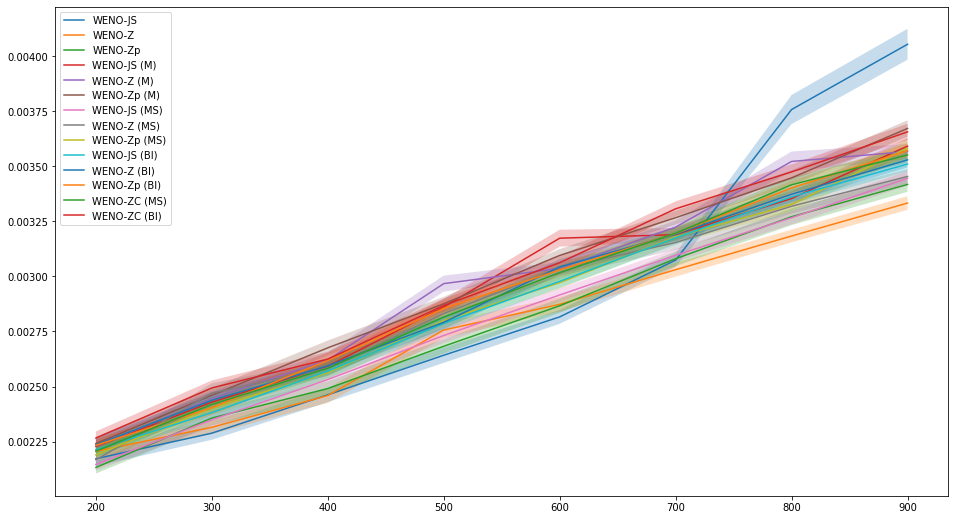

In [84]:
plt.figure(figsize=(16,9))
for i,nome in enumerate(nomes):
    plt.plot(range(200,1000,100),t_mean[nome],label=nome)
    plt.fill_between(range(200,1000,100),y1=t_icu[nome],y2=t_icl[nome],alpha=0.25)
plt.legend()
plt.show()

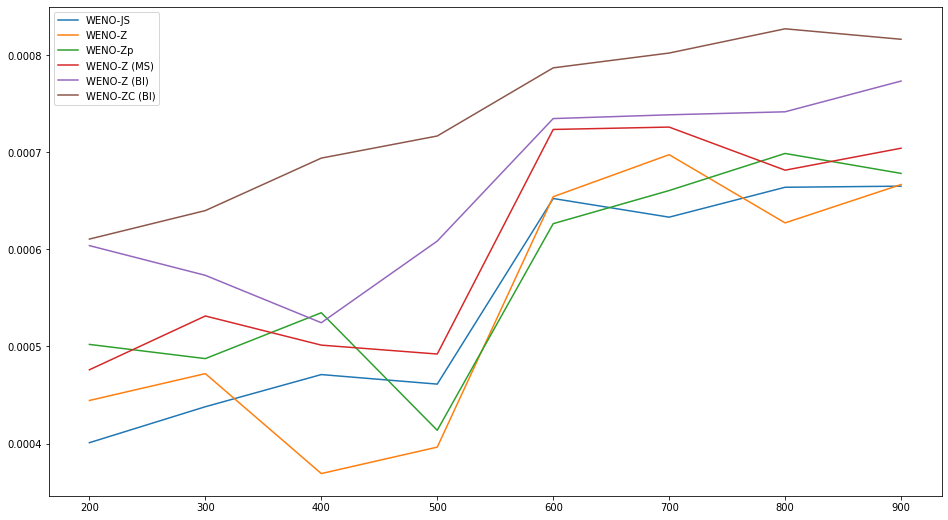

In [89]:
plt.figure(figsize=(16,9))
for i,nome in enumerate(["WENO-JS"     , "WENO-Z"      , "WENO-Zp"     , "WENO-Z (MS)" , "WENO-Z (BI)" , "WENO-ZC (BI)"]):
    plt.plot(range(200,1000,100),t_mean[nome],label=nome)
    #plt.fill_between(range(200,1000,100),y1=t_icu[nome],y2=t_icl[nome],alpha=0.25)
plt.legend()
plt.show()